# Introduction

More than 3 million households in the UK are at risk of malnutrition. Moreover, almost 4 million children in the UK live in households that would struggle to afford to buy enough fruit, vegetables, fish and other healthy foods to meet the official nutrition guidelines. Conseqently, government agency run various programs that offer subsidized meals targeting low-income households. You are hired by the government agency to design an "optimal" subsided meal. 

Minimal daily intakesm of key nutrients (calories and minerals) have been determined by nutrionists. The goal is compose an assortment of food items that minimizes the total cost, while ensuring that the minimum daily intake is guaranteed. This is known as the *diet problem*.

<img src="school_lunch_tray.jpg" width="500">

# Data

You will start by reviewing the data compiled by the nutrionists. In order to compose an optimal diet, you will have access to the following pieces of information:
- Daily intake for different categories of nutrients
- Costs of various food items
- The nutrient composition of each food item

*Select and execute the cells below to define the dictionaries containing the data* 

In [2]:
# Recommended daily values for different categories of nutrients (ignore the unit)
categories = ['calories', 'protein', 'sodium']
minNutrition = {
                'calories': 1800,
                'protein': 200,
                'sodium': 0
                }

In [3]:
# Costs associated with food item (per food item unit)
foods = ['chicken','greens','salad','bread']
cost = {
        'chicken':   1.69,
        'greens':    0.49,
        'salad':     0.49,
        'bread': 0.99}

In [4]:
# Nutrient composition of food item (per food item unit)
nutritionValues = { 
    ('chicken',   'calories'): 420,
    ('chicken',   'protein'):  32,
    ('chicken',   'sodium'):   1190,        
    ('greens',  'calories'): 34,
    ('greens',  'protein'):  15,
    ('greens',  'sodium'):   33,
    ('salad',     'calories'): 50,
    ('salad',     'protein'):  3,
    ('salad',     'sodium'):   420,
    ('bread', 'calories'): 330,
    ('bread', 'protein'):  7,
    ('bread', 'sodium'):   100}

# Q1. Formulate an Optimization Model Using Gurobi

We will now formulate the diet problem as an optimization model. As discussed in class, there are three components:
1. **Decision variables:** We create a decision variable $x_f$ for the quantity picked from each food item $f \in {\rm foods}$, meaning that we have the following decision variables: $x_{chicken}, x_{greens}, x_{salad},x_{bread}$. The quantity in the optimal diet is unknown; $x_f$ could potentially take any non-negative value.  The solver will find an optimal value $x^*_f$ for each food item $f$. For example, if the optimal diet does not contain any "bread", we will obtain $x^*_{bread} = 0$.


2. **Constraints:** We need to guarantee a minimal daily intake for each nutrient. These requirements form an ensemble of *constraints*. For example, we need to ensure that at least 1800 calories are provided by the meal. Mathematically, this requirement is expressed using a linear constraint: 
<br><br>
$$ 420 \cdot x_{chicken} + 34\cdot x_{greens} + 50\cdot x_{salad} + 330\cdot x_{bread} \geq 1800$$
<br>
In this constraint, we multiply the quantity of each food item by the corresponding calorie contribution per unit. The total contribution should exceed the requirement of 1800. We will need one constraint for each nutrient: calories, protein and sodium.
    
    
3. **Objective function:** Lastly, we need to select the objective function. *What should we optimize for?* The goal is find a menu composition that minimizes the total cost. The cost is given by the following expression:
<br><br>
$$ 1.69 \cdot x_{chicken} + 0.49\cdot x_{greens} + 0.49\cdot x_{salad} + 0.99\cdot x_{bread}$$
<br>
We multiply the quantity of each food item by the corresponding cost per unit. The objective function is obtained by taking the sum.

We now write down the optimization model:

$$ \max_{x_f} \quad\quad\quad  1.69 \cdot x_{chicken} + 0.49\cdot x_{greens} + 0.49\cdot x_{salad} + 0.99\cdot x_{bread}$$
$\quad\quad{\rm subject \ to}$
$$x_{chicken}, x_{greens}, x_{salad},x_{bread} \geq 0$$
$$ \quad  420 \cdot x_{chicken} + 34\cdot x_{greens} + 50\cdot x_{salad} + 330\cdot x_{bread} \geq 1800 $$ 
$$ \quad  32 \cdot x_{chicken} + 15\cdot x_{greens} + 3\cdot x_{salad} + 7\cdot x_{bread} \geq 200 $$ 
$$ \quad  1190 \cdot x_{chicken} + 33\cdot x_{greens} + 420\cdot x_{salad} + 100\cdot x_{bread} \geq 0 $$ 

This form of optimization models is referred to as a *linear program*. We often use the abbrevation *LP* to designate a linear program. This is because the constraints and the objective function are affine functions of the decision variables $x_f$.

*In what follows, you will construct this linear program using the Gurobi programming language.*
*Go through each cell and execute the command. Carefully read the comments provided to familiarize yourself with the syntax.*

## Step 0: Create a model object

In [5]:
# The following lines of code import the gurobi package
import gurobipy as gp
from gurobipy import GRB,quicksum

In [6]:
# Create a model object
m = gp.Model("diet")

# Explanations: Each Gurobi model is one "optimization problem" 
# All the information about the optimization problem will be stored in the model object (attributes)
# We will utilize the functions (methods) of the model object to construct and solve the problem.

Set parameter Username
Academic license - for non-commercial use only - expires 2022-03-07


## Step 1: Add the decision variables


The constructs `m.addVar()` and/or `m.addVars()` are used to declare new decision variables in the model `m`.

In [7]:
# Create decision variables for the quantity of each food item in the diet
quantity = m.addVars(foods, lb = 0, name="quantity")

# Explanation: "quantity" is a dictionary where each food (key) is associated with a decision variable (value)
# The argument "lb" is a lower bound on the decision variable. This argument is optional.
# Similarly, the optional argument "ub" gives an upper bound on the decision variables.

# Remark: You could use Python looping constructs and m.addVar() to create
# the decision variables instead.  The following would be equivalent:
#
# quantity = {}
# for f in foods:
#   quantity[f] = m.addVar(name="quantity " + f)

In [8]:
quantity

{'chicken': <gurobi.Var *Awaiting Model Update*>,
 'greens': <gurobi.Var *Awaiting Model Update*>,
 'salad': <gurobi.Var *Awaiting Model Update*>,
 'bread': <gurobi.Var *Awaiting Model Update*>}

## Step 2: Add the constraints


The constructs `m.addConstr()` and `m.addConstrs()` are used to add constraints to the model `m`.

In [10]:
m.addConstrs( (quicksum(nutritionValues[f,c] * quantity[f] for f in foods)
              >= minNutrition[c] for c in categories), "Minimum_requirements")

# Explanation: Each constraint expresses the minimum daily intake for each category
# The argument "quicksum()"" computes the sum of the expression between parenthesis
# The argument "Minimum_requirements" gives a name to each constraint
# Note that the name should not have any space

# Remark: You could use Python looping constructs and m.addCstr() to create
# the constraints one at a time instead.  The following would be equivalent
#
# for c in categories:
#      m.addConstr(
#         quicksum(nutritionValues[f,c] * quantity[f] for f in foods) >= minNutrition[c],
#         "Minimum_requirements"+c)

{'calories': <gurobi.Constr *Awaiting Model Update*>,
 'protein': <gurobi.Constr *Awaiting Model Update*>,
 'sodium': <gurobi.Constr *Awaiting Model Update*>}

## Step 3: Specify an objective function

The constructs `m.setObjective()` is used to add constraints to the model `m`.

In [11]:
# The objective is to minimize the costs
m.setObjective(quantity.prod(cost), GRB.MINIMIZE)

# Explanations: The function prod() allows to compute scalar products on tuple-dictionaries
# For a maximization problem, use GRB.MAXIMIZE instead of GRB.MINIMIZE

# Remark: Using looping constructs, the following would be equivalent!
#
# m.setObjective(quicksum(quantity[f]*cost[f] for f in foods), GRB.MINIMIZE)

In [12]:
# The model can be written into a file (with the suffix .lp)
m.write("diet-problem.lp")

# Once a model is saved, you can open it as a text and read the equations of the model!
#
# You can also load the model into a new model object
m2 = gp.read("diet-problem.lp")
# The new model m2 is an exact copy of m! 
# This is convenient if you want to share the model with someone else

Read LP format model from file diet-problem.lp
Reading time = 0.02 seconds
: 3 rows, 4 columns, 12 nonzeros


## Final step: Solve the diet problem and printout the optimal meal

In [13]:
def printSolution():
    '''
    A best practice is to define a function that prints the solution of the model (if it's not too big to display)
    '''
    if m.status == GRB.OPTIMAL:
        print('\nTotal cost: %g' % m.objVal)
        print('\nQuantity:')
        for f in foods:
            print('%s %g' % (f, quantity[f].x))
            # %s means that the first argument printed is a string
            # %g means that the second argument printed is a real number            
            # You can print as many variables as you wish
            # E.g., "%s %s %g % (a,b,c)" will print two strings a and b followed by the number c
    else:
        print('No solution')
        
m.optimize()
printSolution()

# Explanations: 
# The instruction "m.optimize()" solves the linear program
#
# The model status "m.status" can be "OPTIMAL", "UNBOUNDED" or "INFEASIBLE" (will explain in class)
# The instruction "quantity[f].x" looks-up the optimal quantity of food f
# Alternatively, we could have used the instructions:
# quantityx = m.getAttr('x', quantity) # looks-up the vector of optimal quantities
# for f in foods:
#    print('%s %g' % (f, quantityx[f]))


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 3 rows, 4 columns and 12 nonzeros
Model fingerprint: 0x7ae62a0b
Coefficient statistics:
  Matrix range     [3e+00, 1e+03]
  Objective range  [5e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+03]
Presolve removed 1 rows and 1 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.125000e+02   0.000000e+00      0s
       2    9.0318496e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds (0.00 work units)
Optimal objective  9.031849578e+00

Total cost: 9.03185

Quantity:
chicken 3.87567
greens 5.06523
salad 0
bread 0


### Question: What quantities of each food item are selected in the optimal meal?

Chicken - 3.87567

Greens - 5.06523

Salad - 0

Bread - 0

### Question: How many food products are selected in the optimal diet?

2 (Chicken and Greens)

# Q2. Modify the Model 

In what follows, you will learn how to modify an LP model, by adding or removing constraints.

## Adding a constraint

Right now, we have only guaranteed a minimum intake for each nutrient. In reality, certain nutrients (such as sodium or protein) can be detrimental if the intake is excessive. To compose a healthy, we need to account for the maximum intake recommended by the nutritionist. This piece of information is shown below.

*Go through the next cell and execute the code*

In [14]:
## Maximum recommended daily intake of each nutrient
maxNutrition = {
                'calories': 2200,
                'protein': GRB.INFINITY,
                'sodium': 1779
                }

# Explanation: GRB.INFINITY means that there is no upper limit on the intake of protein
# meaning that the intake can be arbitrarily large.

We will now modify the model by adding new constraints that restrict the maximum intake. Next, we resolve the model.

*Go through the next cell and execute the code*

In [15]:
## Consequently, we add a constraint for each nutrient category by referring to the same model m

max_cstrs = m.addConstrs( (quicksum(nutritionValues[f,c] * quantity[f] for f in foods)
                          <= maxNutrition[c] for c in categories), "Maximum_requirements")

# Remark: You could use Python looping constructs and m.addCstr() to create
# the constraints one at a time instead.  The following would be equivalent
#
# for c in categories:
#  m.addConstr(
#     quicksum(nutritionValues[f,c] * quantity[f] for f in foods) <= maxNutrition[c],
#     "Maximum requirements "+c)

In [16]:
## Lastly, we resolve the model

m.optimize()
printSolution()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 6 rows, 4 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [3e+00, 1e+03]
  Objective range  [5e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.0318496e+00   9.375631e+01   0.000000e+00      0s
       1    9.6092244e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.609224386e+00

Total cost: 9.60922

Quantity:
chicken 0.951564
greens 9.79395
salad 0
bread 3.23439


### Question: Has the menu changed significantly? How many food products are selected in the optimal diet?

Yes.

3 (Chicken, Greens and Bread)

## Removing a constraint

As shown by the command below, it is easy to remove any constraint that has been referenced earlier. You will remove the maximum intake constraints, and resolve the linear program accordingly.

*Go through the next cell and execute the code*

In [17]:
m.remove(max_cstrs)

# Remark 1: The object "max_cstrs" defined earlier allows us to delete the corresponding variables.
# Remark 2: If we had not defined "max_cstrs", we could have used the following code:
# 
# model.remove(model.getConstrs()[-1])
# Remark 2.a: "model.getConstrs()" returns the lists of all constraints
# Remark 2.b: The index "-1" selects the last constraint we introduced

In [18]:
#We resolve the model and the optimal diet should be identical to the inital one

m.optimize()
printSolution()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 3 rows, 4 columns and 12 nonzeros
Model fingerprint: 0x7ae62a0b
Coefficient statistics:
  Matrix range     [3e+00, 1e+03]
  Objective range  [5e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+03]
Presolve removed 1 rows and 1 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.125000e+02   0.000000e+00      0s
       2    9.0318496e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.031849578e+00

Total cost: 9.03185

Quantity:
chicken 3.87567
greens 5.06523
salad 0
bread 0


# Q3 . Practice !

## Q3.a. Solve a more realistic problem

We will now consider a more realistic version of the problem. Additional food items are available to compose the meal (e.g., "pizza"), and other nutrients should be considered (e.g., "fat"). Formulate and solve a linear program, using the same approach as previously. 

*Write your own code in the cells below. Hint: You can copy paste the code above. Always reuse your code!*

In [19]:
# Minimum recommended daily intake for each categories of nutrients
categories = ['calories', 'protein', 'potassium','sodium','fat']
minNutrition = {
                'calories': 1800,
                'protein': 200,
                'potassium': 4700,
                'sodium': 0,
                'fat':0
                }

# Maximum recommended daily intake of each nutrient
maxNutrition = {
                'calories': 2200,
                'protein': GRB.INFINITY,
                'potassium': 8000,
                'sodium': 1779,
                'fat':65
                }

In [20]:
# Costs associated with food products (per unit)
foods = ['hamburger','chicken','hot dog','fries','greens','pizza', 'salad','milk', 'bread']
cost = {'hamburger': 2.49,
        'chicken':   2.09,
        'hot dog':   1.50,
        'fries':     1.89,
        'greens':    0.49,
        'pizza':     2.99,
        'salad':     0.49,
        'milk':      1.59,
        'bread': 0.99}

In [21]:
# Nutrient composition of food products (per unit)
nutritionValues = {
    ('hamburger', 'calories'): 410,
    ('hamburger', 'protein'):  24,
    ('hamburger', 'fat'):      26,
    ('hamburger', 'sodium'):   730,
    ('hamburger', 'potassium'):   271,    
    ('chicken',   'calories'): 420,
    ('chicken',   'protein'):  32,
    ('chicken',   'fat'):      10,
    ('chicken',   'sodium'):   1190,
    ('chicken', 'potassium'):   397,        
    ('hot dog',   'calories'): 560,
    ('hot dog',   'protein'):  20,
    ('hot dog',   'fat'):      32,
    ('hot dog',   'sodium'):   1800,
    ('hot dog', 'potassium'):   152,    
    ('fries',     'calories'): 380,
    ('fries',     'protein'):  4,
    ('fries',     'fat'):      19,
    ('fries',     'sodium'):   370,
    ('fries',     'potassium'):   780,    
    ('greens',  'calories'): 34,
    ('greens',  'protein'):  15,
    ('greens',  'fat'):      0,
    ('greens',  'sodium'):   33,
    ('greens',  'potassium'):   400,    
    ('pizza',     'calories'): 420,
    ('pizza',     'protein'):  15,
    ('pizza',     'fat'):      20,
    ('pizza',     'sodium'):   2400,
    ('pizza',     'potassium'):   950,    
    ('salad',     'calories'): 50,
    ('salad',     'protein'):  3,
    ('salad',     'fat'):      5,
    ('salad',     'sodium'):   420,
    ('salad',     'potassium'):   1430,    
    ('milk',      'calories'): 50,
    ('milk',      'protein'):  18,
    ('milk',      'fat'):      1.1,
    ('milk',      'sodium'):   40,
    ('milk',      'potassium'):   350,    
    ('bread', 'calories'): 330,
    ('bread', 'protein'):  7,
    ('bread', 'fat'):      17,
    ('bread', 'sodium'):   100,
    ('bread', 'potassium'):   100}

In [26]:
# Write your code below
n = gp.Model("diet2")

quantity = n.addVars(foods, lb = 0, name="quantity")
n.addConstrs( (quicksum(nutritionValues[f,c] * quantity[f] for f in foods)
              >= minNutrition[c] for c in categories), "Minimum_requirements")
n.setObjective(quantity.prod(cost), GRB.MINIMIZE)

n.write("diet-problem-2.lp")

def printSolution():
    if n.status == GRB.OPTIMAL:
        print('\nTotal cost: %g' % n.objVal)
        print('\nQuantity:')
        for f in foods:
            print('%s %g' % (f, quantity[f].x))          
    else:
        print('No solution')
        
n.optimize()
printSolution()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 5 rows, 9 columns and 44 nonzeros
Model fingerprint: 0x72d25419
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 5e+03]
Presolve removed 2 rows and 3 columns
Presolve time: 0.01s
Presolved: 3 rows, 6 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.031250e+02   0.000000e+00      0s
       3    8.8333393e+00   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.833339332e+00

Total cost: 8.83334

Quantity:
hamburger 0
chicken 0
hot dog 2.59444
fries 0
greens 9.82133
pizza 0
salad 0.263715
milk 0
bread 0


### Question: What is the optimal meal that minimizes the cost?

hamburger 0

chicken 0

hot dog 2.59444

fries 0

greens 9.82133

pizza 0

salad 0.263715

milk 0

bread 0

## Q3.b. Diversity of diet

One nutritionist is not convinced by the output of the optimization model. She believes that the quantity of bread units is excessive. The subsidized menu might not be popular due to the limited taste for greens in a portion of the population. To remedy this issue, she suggests to add constraints to restrict the maximum quantity of each food item. These new constraints are provided below.

*Formulate and solve a linear program that incorporates the new constraints. Hint: you can reuse almost the same code!*

In [29]:
## Maximum recommended quantity for each product

maxQuantity = {'hamburger': 3.0,
                'chicken':   3.0,
                'hot dog':   3.0,
                'fries':     1.0,
                'greens':    6.0,
                'pizza':     2.0,
                'salad':     10.0,
                'milk':      4.0,
                'bread': 3.0}

In [31]:
# Write your code below
max_cstrs = n.addConstrs((quantity[f] <= maxQuantity[f] for f in foods), "Maximum_requirements")

n.optimize()
printSolution()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.8333393e+00   2.445652e+02   0.000000e+00      0s
       2    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.044880685e+01

Total cost: 10.4488

Quantity:
hamburger 0
chicken 3
hot dog 0.593128
fries 0
greens 6
pizza 0
salad 0.712479
milk 0
bread 0


### Question: How does the diversity requirement affect the optimal meal? How could you remedy this issue?

The quantity of each food category becomes:

hamburger 0

chicken 3

hot dog 0.593128

fries 0

greens 6

pizza 0

salad 0.712479

milk 0

bread 0

The diversity requirement affect the portion of each food item. The portion of green and hot dog decrease, and there's chicken in the diet menu. 

## Q3.c - Sensitivity analysis (Optional Bonus)

Sofia is an economist working for the government. She is concerned about the cost of the meal determined in question Q3.a. She would like to understand how the cost evolves if the government negotiates better deals to procure the food items. In particular, she would like you to plot the cost of the optimal meal as a function of the price of "milk".

*Plot the optimal cost (cost of the optimal meal) as a function of the per-unit price of "milk". To this end, you should vary the per-unit price of "milk" from 0.0 to 3.0, by increments of 0.01.*

*Hint: Re-run the optimization for each per-unit price.*

In [56]:
# Write your code below
import numpy as np
milk_price = np.arange(0.0,3.01,0.01)
optimal_cost = []

for price in milk_price:
    cost = {'hamburger': 2.49,
        'chicken':   2.09,
        'hot dog':   1.50,
        'fries':     1.89,
        'greens':    0.49,
        'pizza':     2.99,
        'salad':     0.49,
        'milk':      price,
        'bread': 0.99}
    n.setObjective(quantity.prod(cost), GRB.MINIMIZE)
    n.optimize()
    if n.status == GRB.OPTIMAL:
        opt_cost = n.objVal
        optimal_cost.append(opt_cost)

#print(optimal_cost)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3442164e+28   6.583372e+30   1.737687e-01      0s
       4    6.5352240e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.535224041e+00
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-02, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    O

Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.0952240e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.095224041e+00
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1352240e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.135

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6552240e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.655224041e+00
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6952240e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.695224041e+00
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient stat

Optimal objective  8.215224041e+00
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.2552240e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  8.255224041e+00
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.   

Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.8152240e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  8.815224041e+00
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7097429e+26   3.670675e+30   6.838972e-04      0s
       1    8.8509972e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds (0.00 work units)
Optimal objective

  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.2705630e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  9.270562959e+00
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.3028373e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  9.302837250e+00
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 column

Optimal objective  9.722403040e+00
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.7546773e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  9.754677331e+00
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.   

Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0206517e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.020651741e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0238792e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.023879170e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5

  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0431098e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.043109783e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0431806e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.043180577e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 column

Optimal objective  1.044100896e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0441717e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044171690e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.   

Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient stat

Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.   

Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5

       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solv

  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical proces


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range       

Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient stat

Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0448807e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.044880685e+01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 9 columns and 62 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Iteration    Objective       Primal Inf.   

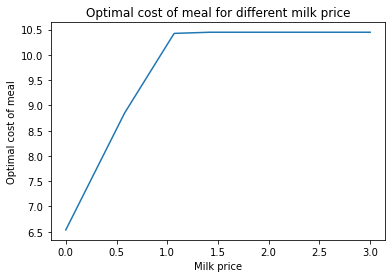

In [58]:
import matplotlib.pyplot as plt
plt.plot(milk_price,optimal_cost)
plt.xlabel('Milk price')
plt.ylabel('Optimal cost of meal')
plt.title('Optimal cost of meal for different milk price')
plt.show()

### Question: Describe the shape of the plot. How do you explain the shape?

The plot is like a trapezoid.

When milk price is beloe around 1.2, the optimal cost increases as the milk price increase. After the milk price reaches certain point (around 1.2), the optimal cost stay the same at around 10.4 when milk price keep increasing.